# Playing with concurrency
## A short story about `concurrent.futures`

In [1]:
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
%matplotlib inline

Let's write some functions that do stuff (a more IRL-based use case later on).

In [2]:
# %%writefile helpers.py

def n_fibonacci(n=10):
    """Calculate the Nth Fibonacci number"""
    i = 0
    x = 1
#     print(x)
    for __ in range(n):
        x, i = x + i, x
#         print(x)
    return x

def fake_write(whatevs=None):
    """Take some time as if it were writing to disk/calling a rest API"""
#     long_time = np.random.randint(1,5)
    long_time = 1. + np.random.random()
    time.sleep(long_time)
    return "Done with {} after {} secs".format(whatevs, long_time)

def calc_length(x):
    """Typically x is an int"""
    return len(str(x))

def calc_lengths(iterable_object):
    """Generate lenghts of values from generator.
    
    Works for any iterable.
    """
    for x in iterable_object:
        yield calc_length(x)

def print_stuff(generator_object):
    """Print values as they are generated"""
    for x in generator_object:
        print(x)

In [3]:
%time x = n_fibonacci(500000)
len(str(x))

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.52 s


104494

Let's create an array of integers to act as input for our functions:

In [4]:
randints = 500000 + np.random.randint(1, 10, 8)
randints

array([500007, 500004, 500007, 500001, 500002, 500001, 500007, 500009])

How long does it take to process the whole array?

In [5]:
%%time
results = (
    n_fibonacci(n) for n in randints
)
print_stuff(calc_lengths(results))

104496
104495
104496
104494
104495
104494
104496
104496
CPU times: user 21.2 s, sys: 4 ms, total: 21.2 s
Wall time: 21.2 s


In [6]:
%%time
results = map(
    n_fibonacci, randints
)
print_stuff(calc_lengths(results))

104496
104495
104496
104494
104495
104494
104496
104496
CPU times: user 21.3 s, sys: 0 ns, total: 21.3 s
Wall time: 21.3 s


This is definitely too long... how can one improve it?

### Multiprocessing through `concurrent.futures`

In [7]:
%%time
with ProcessPoolExecutor() as p_executor:
    results = p_executor.map(n_fibonacci, randints)
#     printout = p_executor.map(calc_length, results)
#     print(list(printout))
    print_stuff(calc_lengths(results))

104496
104495
104496
104494
104495
104494
104496
104496
CPU times: user 1.14 s, sys: 8 ms, total: 1.14 s
Wall time: 6.14 s


This is better, but shouldn't it be `n_procs` better?  
Let's take a deeper look:

In [8]:
start = time.time()
with ProcessPoolExecutor() as p_executor:
    checkpoint_a = time.time()
    results = p_executor.map(n_fibonacci, randints, chunksize=2)
    print_stuff(calc_lengths(results))
    checkpoint_b = time.time()
end = time.time()
print("Pool setup time: {} secs".format(checkpoint_a - start))
print("Computation time: {} secs".format(checkpoint_b - checkpoint_a))
print("Teardown time: {} secs".format(end - checkpoint_b))

104496
104495
104496
104494
104495
104494
104496
104496
Pool setup time: 0.0004532337188720703 secs
Computation time: 6.530499219894409 secs
Teardown time: 0.0052068233489990234 secs


There is minimal overhead for setting up the pool of processes (about 1 ms).  
Most overhead is due to communication between processes (i.e. sending data back and forth from processes).

One can analyse how scaling evolves with the length of the single task.

In [9]:
plot_data = []
with ProcessPoolExecutor() as p_executor:
    for i in range(1, 6):
        print(i)
        randints = i * 50000 + np.random.randint(1, 10, 32)
        start = time.time()
        results = (
            n_fibonacci(n) for n in randints
        )
#         print_stuff(calc_lengths(results))
        [__ for __ in results]
        seq_time = time.time() - start
        start = time.time()
        results = p_executor.map(n_fibonacci, randints)
        [__ for __ in results]
        plot_data.append((i, seq_time, time.time() - start))
print(plot_data)
# plt.plot(*plot_data);

1
2
3
4
5
[(1, 0.9554667472839355, 0.29555702209472656), (2, 3.5456128120422363, 0.9413728713989258), (3, 7.762457847595215, 2.3403379917144775), (4, 13.664617538452148, 3.620365858078003), (5, 21.658860445022583, 5.820950269699097)]


In [10]:
two_procs_data = []
with ProcessPoolExecutor(2) as p_executor:
    for i in range(1, 6):
        print(i)
        randints = i * 50000 + np.random.randint(1, 10, 32)
        start = time.time()
        results = p_executor.map(n_fibonacci, randints, chunksize=16)
        [__ for __ in results]
        two_procs_data.append((i, time.time() - start))

1
2
3
4
5


/home/guzzo/Software/anaconda3/envs/concurrent-futures/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


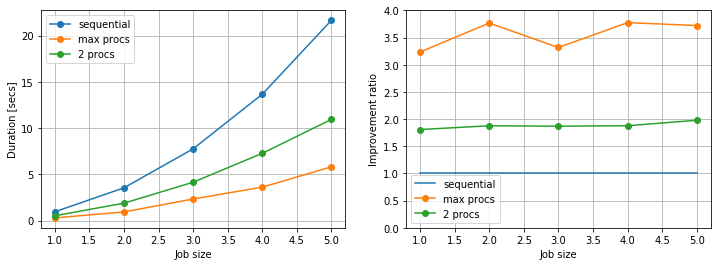

In [11]:
plt.figure(figsize=(12, 4))
x = [x[0] for x in plot_data]
y_seq = [x[1] for x in plot_data]
y_para = [x[2] for x in plot_data]
y_ratio = [x[1]/x[2] for x in plot_data]
y_para_two = [x[1] for x in two_procs_data]
y_ratio_two = [x[0][1]/x[1][-1] for x in zip(plot_data, two_procs_data)]
plt.subplot(1, 2, 1)
plt.xlabel("Job size")
plt.ylabel("Duration [secs]")
plt.plot(x, y_seq, '-o', label="sequential")
plt.plot(x, y_para, '-o', label="max procs")
plt.plot(x, y_para_two, '-o', label="2 procs")
# plt.yscale('log')
plt.legend()
plt.grid();
plt.subplot(1, 2, 2)
plt.xlabel("Job size")
plt.ylabel("Improvement ratio")
plt.plot(x, np.ones(len(x)), label="sequential")
plt.plot(x, y_ratio, '-o', label="max procs")
plt.plot(x, y_ratio_two, '-o', label="2 procs")
plt.ylim((0,4))
plt.legend()
plt.grid();

In [12]:
y_ratio_two

[1.807564991987212,
 1.8767705727431085,
 1.8690502652184895,
 1.8779026267542398,
 1.978222335854618]

### Now what?

We have calculated important stuff, and we want to store it/send it somewhere safe.

Let's say we save it to disk for now.
How long is that going to take?

In [13]:
randints = 3 * 100000 + np.random.randint(1, 10, 32)

In [14]:
%%time
with ProcessPoolExecutor() as p_exec:
    results = p_exec.map(n_fibonacci, randints)
    myres = list(results)

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 8.27 s


In [15]:
%%time
for r in myres:
    fake_write(r)

CPU times: user 2.1 s, sys: 4 ms, total: 2.1 s
Wall time: 51.2 s


In [16]:
%%time
with ProcessPoolExecutor() as p:
    results = p.map(fake_write, myres)
    print_stuff(calc_lengths(results))

62738
62738
62738
62739
62739
62737
62737
62737
62738
62737
62739
62738
62738
62739
62737
62738
62738
62737
62738
62738
62737
62738
62737
62738
62738
62738
62737
62739
62737
62737
62738
62737
CPU times: user 32 ms, sys: 16 ms, total: 48 ms
Wall time: 13.6 s


In [17]:
%%time
with ThreadPoolExecutor() as p:
    results = p.map(fake_write, myres)
    print_stuff(calc_lengths(results))

62738
62738
62738
62739
62738
62737
62737
62737
62738
62737
62739
62738
62738
62737
62737
62738
62739
62738
62739
62739
62737
62737
62737
62738
62738
62738
62737
62739
62737
62737
62737
62736
CPU times: user 1.79 s, sys: 20 ms, total: 1.81 s
Wall time: 3.49 s


How does it actually scale?

In [21]:
data = []
for i in range(1, 6):
    print(i)
    n_exec = i*5
    with ThreadPoolExecutor(n_exec) as p:
        start = time.time()
        results = p.map(fake_write, myres)
        list(calc_lengths(results))
        data.append((n_exec, time.time() - start))

1
2
3
4
5


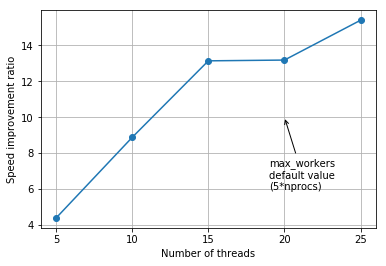

In [22]:
x = [x[0] for x in data]
y = [50/x[1] for x in data]
plt.plot(x, y, '-o')
# plt.ylim((0,12))
plt.xticks(x)
plt.xlabel("Number of threads")
plt.ylabel("Speed improvement ratio")
# plt.arrow(20, 6, 0, 3)
plt.annotate("max_workers\ndefault value\n(5*nprocs)", xy=(20, 10), xytext=(19,6), arrowprops=dict(arrowstyle="->"))
plt.grid();

### Combining everything together
Can we use these tools to optimize all parts of a program?

In [23]:
%%time
randints = 3 * 100000 + np.random.randint(1, 10, 32)
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        cpu_results = pp.map(n_fibonacci, randints)
        cpu_results = pp.map(calc_length, cpu_results)
        th_results = tp.map(fake_write, cpu_results)
        print_stuff(th_results)

Done with 62697 after 1.724393729182347 secs
Done with 62697 after 1.8738078503313356 secs
Done with 62698 after 1.8053980048324214 secs
Done with 62698 after 1.4419786339756695 secs
Done with 62699 after 1.6762163576508184 secs
Done with 62697 after 1.3449874494509144 secs
Done with 62698 after 1.5150681650428952 secs
Done with 62697 after 1.870407560675757 secs
Done with 62698 after 1.597669516898116 secs
Done with 62698 after 1.7656136310068193 secs
Done with 62698 after 1.8265382870046194 secs
Done with 62697 after 1.3790359371326688 secs
Done with 62697 after 1.6415926307632058 secs
Done with 62698 after 1.796798956413907 secs
Done with 62698 after 1.0623397609756484 secs
Done with 62698 after 1.0609045695169828 secs
Done with 62698 after 1.2174601426874316 secs
Done with 62697 after 1.5273809326143617 secs
Done with 62698 after 1.7878906258712504 secs
Done with 62697 after 1.5510161907580895 secs
Done with 62698 after 1.7087365883812513 secs
Done with 62697 after 1.61719654609834

In [24]:
%%time
randints = 3 * 100000 + np.random.randint(1, 10, 32)
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        cpu_results = pp.map(n_fibonacci, randints)
        p_futures = []
        t_futures = []
        for res in cpu_results:
            p_futures.append(
                pp.submit(calc_length, res)
            )
        for f in concurrent.futures.as_completed(p_futures):
            t_futures.append(
                tp.submit(fake_write, f.result())
            )
#         for res in cpu_results:
#             mylen = calc_length(res)
#             tp.submit(fake_write, mylen)
        for f in concurrent.futures.as_completed(t_futures):
            print(f.result())

Done with 62697 after 1.072164726366464 secs
Done with 62698 after 1.178858345815902 secs
Done with 62697 after 1.2135406752383922 secs
Done with 62698 after 1.3083323412225831 secs
Done with 62697 after 1.3457600476996578 secs
Done with 62699 after 1.4126906460710642 secs
Done with 62698 after 1.4658467417446914 secs
Done with 62697 after 1.6080121696312641 secs
Done with 62698 after 1.5475815275849523 secs
Done with 62698 after 1.560774382410027 secs
Done with 62698 after 1.5545395329003497 secs
Done with 62698 after 1.6913499266321448 secs
Done with 62698 after 1.6307767092764425 secs
Done with 62699 after 1.6931858092890415 secs
Done with 62698 after 1.7934175827695733 secs
Done with 62698 after 1.8594052556176255 secs
Done with 62698 after 1.8815365733329403 secs
Done with 62698 after 1.9672082543797227 secs
Done with 62698 after 1.9406108346829827 secs
Done with 62697 after 1.9816510196243589 secs
Done with 62697 after 1.187347103250215 secs
Done with 62698 after 1.75949387608826

### Quick code analysis

This piece of code has two main parts (does it look familiar?):

1. A computing part.
2. An I/O part.

Let's take a look at each one separately.

### Using map

In [97]:
%%time
with ProcessPoolExecutor() as p_executor:
    with ThreadPoolExecutor() as executor:
        results = p_executor.map(n_fibonacci, randints)
        results = executor.map(fake_write, results)
        print(list(results)[:3])

[None, None, None]
CPU times: user 60 ms, sys: 24 ms, total: 84 ms
Wall time: 24.3 s


### Using submit

In [99]:
%%time
with ProcessPoolExecutor() as p_executor:
    with ThreadPoolExecutor() as executor:
        futures = [
            p_executor.submit(n_fibonacci, randn) for randn in randints
        ]
        t_futures = [
            executor.submit(
                fake_write,
                future.result()
            ) for future in concurrent.futures.as_completed(futures)
        ]
        concurrent.futures.wait(t_futures)

CPU times: user 60 ms, sys: 28 ms, total: 88 ms
Wall time: 28.7 s


## Improvements

Possible improvements include:

- Optimize your code
- 


### Chunksize

In [59]:
%%time
with ProcessPoolExecutor() as p_executor:
    with ThreadPoolExecutor() as executor:
        results = p_executor.map(n_fibonacci, randints, chunksize=32)
        executor.map(fake_write, results)

CPU times: user 44 ms, sys: 24 ms, total: 68 ms
Wall time: 24.1 s


In [25]:
def n_fibonacci(n=10):
    """Calculate the Nth Fibonacci number"""
    i = 0
    x = 1
#     print(x)
    for __ in range(n):
        x, i = x + i, x
#         print(x)
    return x

In [29]:
def n_fib(n=10):
#     i_0 = 0
#     i_1 = 1
    if n != 0 and n != 1:
        return n_fib(n-1) + n_fib(n-2)
    else:
        return n

In [36]:
%timeit n_fib()

23.1 µs ± 146 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
%timeit n_fibonacci()

606 ns ± 2.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
